# Gestión de carteras

# Importamos librerias

In [1]:
import math
import numpy as np
import scipy.stats as scs
import statsmodels.api as sm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Definimos las características de los gráficos

In [2]:
sns.set_style("whitegrid")

## Recuperamos precios y calculamos rentabilidades

Tienes que autorizar a google colab para tener acceso a tu google drive

In [10]:
filename="https://raw.githubusercontent.com/alfonso-santos/Python-aplicado-gestion-carteras/fernando/Tema_2/data/tr_eikon_eod_data.csv"
raw = pd.read_csv(filename,index_col=0, parse_dates=True)
raw.head()

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
Date,,,,,,,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.4323,1096.35,NaN,NaN
2010-01-04,30.572827,30.950,20.88,133.90,173.08,113.33,1132.99,20.04,1.4411,1120.00,47.71,109.80
2010-01-05,30.625684,30.960,20.87,134.69,176.14,113.63,1136.52,19.35,1.4368,1118.65,48.17,109.70
2010-01-06,30.138541,30.770,20.80,132.25,174.26,113.71,1137.14,19.16,1.4412,1138.50,49.34,111.51
2010-01-07,30.082827,30.452,20.60,130.00,177.67,114.19,1141.69,19.06,1.4318,1131.90,49.10,110.82


In [11]:
symbols = ['SPY', 'GLD', 'AAPL.O', 'MSFT.O']
data = (pd.DataFrame(raw[symbols]).dropna())
print(data)

               SPY     GLD      AAPL.O  MSFT.O
Date                                          
2010-01-04  113.33  109.80   30.572827  30.950
2010-01-05  113.63  109.70   30.625684  30.960
2010-01-06  113.71  111.51   30.138541  30.770
2010-01-07  114.19  110.82   30.082827  30.452
2010-01-08  114.57  111.37   30.282827  30.660
...            ...     ...         ...     ...
2018-06-25  271.00  119.89  182.170000  98.390
2018-06-26  271.60  119.26  184.430000  99.080
2018-06-27  269.35  118.58  184.160000  97.540
2018-06-28  270.89  118.22  185.500000  98.630
2018-06-29  271.28  118.65  185.110000  98.610

[2138 rows x 4 columns]


Voy a crear un índice. Divido los precios actuales con los del momento inicial `data.iloc[0]`

<AxesSubplot:xlabel='Date'>

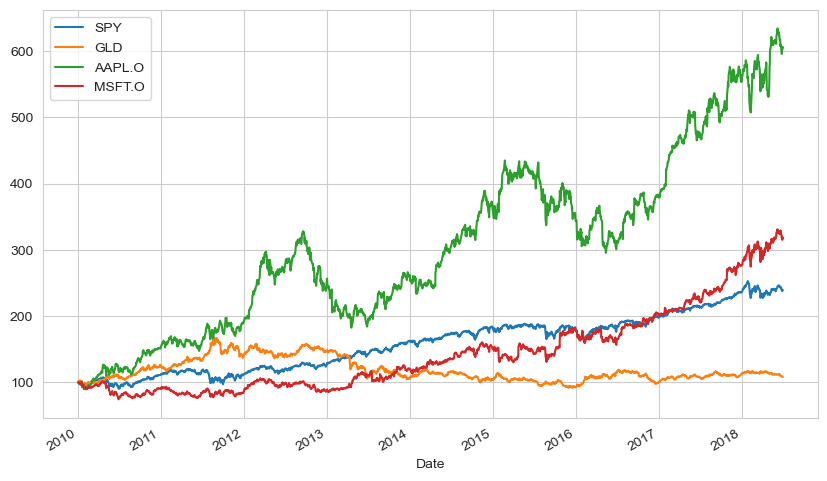

In [12]:
(data / data.iloc[0] * 100).plot(figsize=(10, 6))

Vamos a calcular las rentabilidades logarítmicas y posteriormente representar sus histogramas.

bins=50: Este argumento determina la cantidad de "contenedores" o "bins" en los que se agruparán las rentabilidades para crear el histograma. En otras palabras, especifica cuántos intervalos diferentes se utilizarán para dividir el rango de rentabilidades observadas. En tu caso, se han elegido 50 bins, lo que significa que se dividirá el rango total de rentabilidades en 50 intervalos. Un valor más alto de bins proporcionaría un histograma más detallado con más barras, mientras que un valor más bajo de bins daría un histograma más suavizado con menos barras. La elección del número adecuado de bins depende de la distribución de tus datos y de tus preferencias visuales.

figsize=(10, 8): Este argumento controla el tamaño de la figura en la que se muestra el histograma. Es una tupla que especifica el ancho y el alto de la figura en pulgadas. En este caso, la figura tendrá un ancho de 10 pulgadas y una altura de 8 pulgadas. Ajustar el tamaño de la figura puede ser útil para controlar la legibilidad y la presentación del histograma en tu entorno de trabajo. Puedes cambiar estos valores según tus necesidades para obtener una figura que se ajuste mejor a tu diseño.

array([[<AxesSubplot:title={'center':'SPY'}>,
        <AxesSubplot:title={'center':'GLD'}>],
       [<AxesSubplot:title={'center':'AAPL.O'}>,
        <AxesSubplot:title={'center':'MSFT.O'}>]], dtype=object)

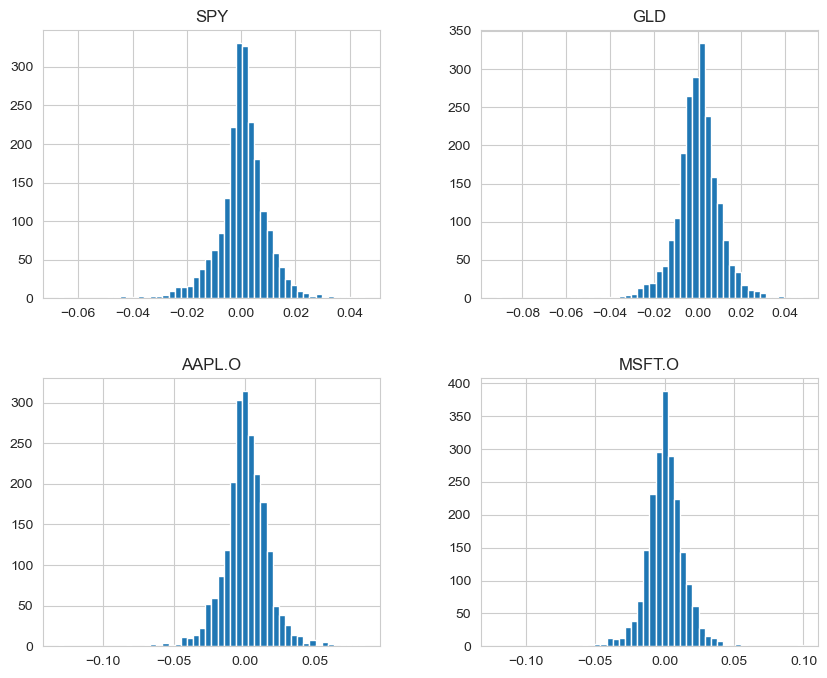

In [13]:
rets = np.log(data / data.shift(1))
rets.hist(bins=50, figsize=(10, 8))

## Creamos una cartera aleatoria con cuatro títulos

In [14]:
noa = len(symbols)
print(noa)

4


Los datos están expresados en términos diarios. Consideramos que se negocian 252 días al año.

In [15]:
rets.mean() * 252

SPY       0.102928
GLD       0.009141
AAPL.O    0.212359
MSFT.O    0.136648
dtype: float64

In [ ]:
rets.cov() * 252

,SPY,GLD,AAPL.O,MSFT.O
SPY,0.021939,0.000062,0.021039,0.022244
GLD,0.000062,0.026209,0.001513,-0.000347
AAPL.O,0.021039,0.001513,0.063773,0.023427
MSFT.O,0.022244,-0.000347,0.023427,0.050917


Utilizamos `np.random.random(noa)`para generar 4 números aleatorios que nos ayudarán a generar una cartera aleatoria. Lamentablemente no sumarán uno por lo que dividimos por la suma de los cuatro dígitos.

In [16]:
weights = np.random.random(noa)
print(weights)

[0.89285624 0.25675596 0.35041399 0.32078095]


In [17]:
weights /= np.sum(weights)
print(weights)

[0.49036288 0.14101217 0.19244981 0.17617514]


Calculamos su rentabilidad media

In [18]:
np.dot(rets.mean().T *252, weights)

0.11670367768019599

Calculamos su varianza y desviación típica

In [19]:
np.dot(weights.T, np.dot(rets.cov() * 252, weights))

0.019214873396784175

In [20]:
math.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))

0.13861772396336688

Definimos una función que nos permita calcular la rentabilidad esperada de una cartera $(\mu)$.

In [21]:
def port_ret(weights):
    return np.dot(rets.mean().T *252, weights)

Definimos una función que nos pemita calcular la desviación típica de una cartera $(\sigma)$.

In [22]:
def port_vol(weights):
    return np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))

Creamos dos listas vacias para guardar las rentabilidades `prets` y las desviaciones típicas `pvols`.

In [23]:
prets = []
pvols = []

Creamos un bucle donde `p` tomará valores entre 0 y 2499, eso nos permitirá crear 2500 carteras aleatorias.
- Generamos los números aleatorios
- Normalizamos dichos números para convertirlos en ponderaciones.
- Utilizamos las funciones para calcular media y desviación típica de las carteras y las guardamos en las listas vacias vacias `append(port_ret(weights))`

In [24]:
for p in range (2500):
    weights = np.random.random(noa)
    weights /= np.sum(weights)
    prets.append(port_ret(weights))
    pvols.append(port_vol(weights))

Convertimos las listas en matrices

In [25]:
prets = np.array(prets)
pvols = np.array(pvols)

Definimos el gráfico que nos muestre las 2500 carteras generadas de manera aleatoria.
- Definimos el tamaño `plt.figure(figsize=(10, 6))`
- Creamos un gráfico donde cada punto es una cartera que viene definido en el eje de las x por `pvols` y en el eje de las y por `prets`, además le añadimos un mapa de calor `plt.scatter(pvols, prets, c=prets / pvols, marker='o', cmap='coolwarm')`

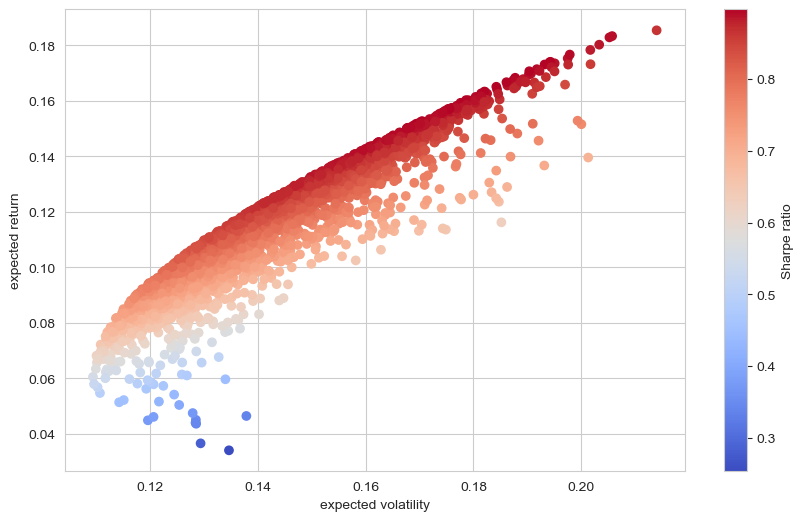

In [26]:
plt.figure(figsize=(10, 6))
plt.scatter(pvols, prets, c=prets / pvols, marker='o', cmap='coolwarm')
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')